In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, f
from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(4)

In [2]:
class SLR():
    """
    Author: Lucius Vo <https://github.com/vohuynhquangnguyen>
    Construct a simple linear regression model and conduct required estimations and hypothesis test.
    """
    def __init__(self, src: str, predictor: str, response: str) -> None:
        super(SLR, self).__init__
        self.src = src
        self.predictor = predictor
        self.response = response

    def load_data(self):
        """
        Load the dataset from a .csv file using Pandas file handler.
        """
        df = pd.read_csv(self.src)
        self.X = np.array(df[self.predictor])
        self.Y = np.array(df[self.response])
        pass
    
    def fit(self):
        """
        Compute the parameters of the fitted model using the ordinary least square (OLS) method.
        """        
        self.x_bar = np.mean(self.X)
        self.y_bar = np.mean(self.Y)

        self.SS_xx = sum((x - self.x_bar) ** 2 for x in self.X)
        self.SS_yy = sum((y - self.y_bar) ** 2 for y in self.Y)
        self.SS_xy = sum((x - self.x_bar) * (y - self.y_bar) for (x,y) in zip(self.X, self.Y))
 
        self.b1_hat = self.SS_xy / self.SS_xx
        self.b0_hat = self.y_bar - self.b1_hat * self.x_bar
        pass    

    def compute_standard_error(self):
        """
        Compute the standard errors of the fitted model's parameters (slope and intercept).
        """
        self.n = len(self.Y)
        self.e = np.array([y - (self.b0_hat + self.b1_hat * x) for (x,y) in zip(self.X, self.Y)])
        self.SS_E = sum((y - (self.b0_hat + self.b1_hat * x)) ** 2 for (x,y) in zip(self.X, self.Y))
        self.se = self.SS_E / (self.n - 2)
        self.se_b1_hat = (self.se / self.SS_xx) ** (1/2)
        self.se_b0_hat = (self.se * ( 1 / self.n + self.x_bar ** 2 / self.SS_xx)) ** (1/2)
        pass

    def ANOVA(self):
        """
        Conduct the analysis of variance (ANOVA) on the fitted model.
        """
        self.SS_R = sum(((self.b0_hat + self.b1_hat * x) - self.y_bar) ** 2 for x in self.X)
        self.SS_T = self.SS_R + self.SS_E
        self.Rsquare = self.SS_R / self.SS_T
        pass

    def hypothesis_test(self, level: float = 0.95):
        """
        Conduct the hypothesis test on the fitted model at the {level} significant level (default is 95%).
        """
        self.level = level

        self.compute_standard_error()

        ##
        # Hypothesis test on the fitted model's parameters (two-tailed T-test):
        #
        self.t_b1_hat = (self.b1_hat - 0) / self.se_b1_hat
        self.t_b0_hat = (self.b0_hat - 0) / self.se_b0_hat
        
        self.df = self.n - 2
        self.t_c = t.ppf(self.level, df = self.df)
        self.pval_b1 = t.sf(self.t_b1_hat, self.df) * 2
        self.pval_b0 = t.sf(self.t_b0_hat, self.df) * 2

        ##
        # Hypothesis test on the Pearson correlation coefficient (two-tailed T-test):
        #
        self.r = self.SS_xy / (self.SS_xx * self.SS_yy) ** (1/2)
        self.t_r = self.r * (self.df / (1 - self.r ** 2)) * (1/2)
        self.pval_r = t.sf(self.t_r, self.df) * 2

        ##
        # Hypothesis test on the significant of regression (two-tailed T-test):
        #
        self.ANOVA()
        self.F = (self.SS_R / 1) / (self.SS_E / self.df)
        self.pval_F = f.sf(self.F, self.df, self.df) * 2
        pass

    def compute_intervals(self, level: float = 0.95):
        """
        Compute the confidence intervals for the fitted model's parameters:
        """
        self.level = level
        self.t_c = t.ppf(self.level, df = self.df)

        self.b0_hat_lwr = self.b0_hat - self.t_c * self.se_b0_hat 
        self.b0_hat_upr = self.b0_hat + self.t_c * self.se_b0_hat 

        self.b1_hat_lwr = self.b1_hat - self.t_c * self.se_b1_hat 
        self.b1_hat_upr = self.b1_hat + self.t_c * self.se_b1_hat 
        pass

    def visualize(self):
        """
        Visualize the entire analysis process:
        """

        ##
        # Visualize the loaded data:
        #
        fig , axs = plt.subplots(1, 2, figsize = (10,5), dpi = 100)
        self.nbins = (max(self.X) - min(self.X)) * (self.n ** (1/3)) /(3.49 * np.std(self.X))
        axs[0].hist(self.X, bins = int(self.nbins))
        axs[0].set_title(f"{self.predictor}")
        axs[0].grid(True)

        self.nbins = (max(self.Y) - min(self.Y)) * (self.n ** (1/3)) /(3.49 * np.std(self.Y))
        axs[1].hist(self.Y, bins = int(self.nbins))
        axs[1].set_title(f"{self.response}")
        axs[1].grid(True)
        fig.tight_layout()

        ##
        # Visualize the regression analysis:
        #
        self.func = lambda x: self.b0_hat + self.b1_hat * x
        fig , axs = plt.subplots(1, 2, figsize = (10,5), dpi = 100)
        axs[0].scatter(self.X, self.Y, s = 20)
        axs[0].plot(self.X, self.func(self.X), color = 'red', linestyle = 'dashed')
        axs[0].set_xlabel(self.predictor)
        axs[0].set_ylabel(self.response)
        axs[0].set_title(f"{self.response} vs. {self.predictor}")
        axs[0].grid(True)

        axs[1].scatter(self.Y, self.e / self.se, s = 20)
        axs[1].axhline(y = 0, color = 'red')
        axs[1].set_xlabel(self.response)
        axs[1].set_ylabel("Standardized Residual")
        axs[1].set_title(f"Residual Analysis")
        axs[1].grid(True)

        fig.tight_layout()
        pass

    def rounding_values(self):
        """
        Round all computed parameters (slope, intercept, standard errors, etc.) to four decimal places.
        """
        self.e_stde = round(self.se ** (1/2), 4)
        self.e_min = round(np.min(self.e), 4)
        self.e_max = round(np.max(self.e), 4)
        self.e_q1 = round(np.quantile(self.e, .25), 4)
        self.e_q2 = round(np.median(self.e), 4)
        self.e_q3 = round(np.quantile(self.e, .25), 4)

        self.b0_hat = round(self.b0_hat, 4)
        self.b0_hat_lwr = round(self.b0_hat_lwr, 4)
        self.b0_hat_upr = round(self.b0_hat_upr, 4)
        self.se_b0_hat = round(self.se_b0_hat, 4)
        self.t_b0_hat = round(self.t_b0_hat, 4)

        self.b1_hat = round(self.b1_hat, 4)
        self.se_b1_hat = round(self.se_b1_hat, 4)
        self.b1_hat_lwr = round(self.b1_hat_lwr, 4)
        self.b1_hat_upr = round(self.b1_hat_upr, 4)
        self.t_b1_hat = round(self.t_b1_hat, 4)

        self.Rsquare = round(self.Rsquare, 4)
        self.r = round(self.r, 4)
        self.F = round(self.F, 4)
        pass

    def summary(self):
        """
        Generate a full analysis report.
        """
        self.load_data()
        self.fit()
        self.compute_standard_error()
        self.ANOVA()
        self.hypothesis_test()
        self.compute_intervals()
        self.rounding_values()

        ##
        # Generate a report:
        #
        print(f"\n\t  Min \t Q1 \t Median \t Q3 \tMax")
        print(f"Residuals: {self.e_min} \t {self.e_q1} \t {self.e_q2} \t {self.e_q3} \t {self.e_max}")

        print(f"\n\t  Coefficient \t Std. Error \t 2.5% \t 97.5% \t t-Statistic \t Pr(>|t|) at {100 * self.level}%")
        print(f"Intercept: {self.b0_hat} \t {self.se_b0_hat} \t {self.b0_hat_lwr} \t {self.b0_hat_upr} \t {self.t_b0_hat} \t {self.pval_b0}")
        print(f"{self.predictor}: {self.b1_hat} \t {self.se_b1_hat} \t {self.b1_hat_lwr} \t {self.b1_hat_upr} \t {self.t_b1_hat} \t {self.pval_b1}")

        print(f"\nResidual Std. Error: {self.e_stde } on {self.df} DF")
        print(f"R-square: {self.Rsquare}")
        print(f"Pearson correlation coef.: {self.r}, p-value: {self.pval_r}")
        print(f"F-statistic: {self.F} on 1 predictor and {self.df} DF, p-value: {self.pval_F}")

        self.visualize()
        
        pass



	  Min 	 Q1 	 Median 	 Q3 	Max
Residuals: -282.1706 	 -24.8289 	 1.8074 	 -24.8289 	 188.792

	  Coefficient 	 Std. Error 	 2.5% 	 97.5% 	 t-Statistic 	 Pr(>|t|) at 95.0%
Intercept: 1.3587 	 13.7682 	 -21.5751 	 24.2924 	 0.0987 	 0.9216570019132004
Market_Val: 1.4083 	 0.0369 	 1.3468 	 1.4698 	 38.1322 	 2.1120509853669011e-50

Residual Std. Error: 68.7566 on 74 DF
R-square: 0.9516
Pearson correlation coef.: 0.9755, p-value: 3.7390046863650894e-145
F-statistic: 1454.0619 on 1 predictor and 74 DF, p-value: 1.603233725442157e-96


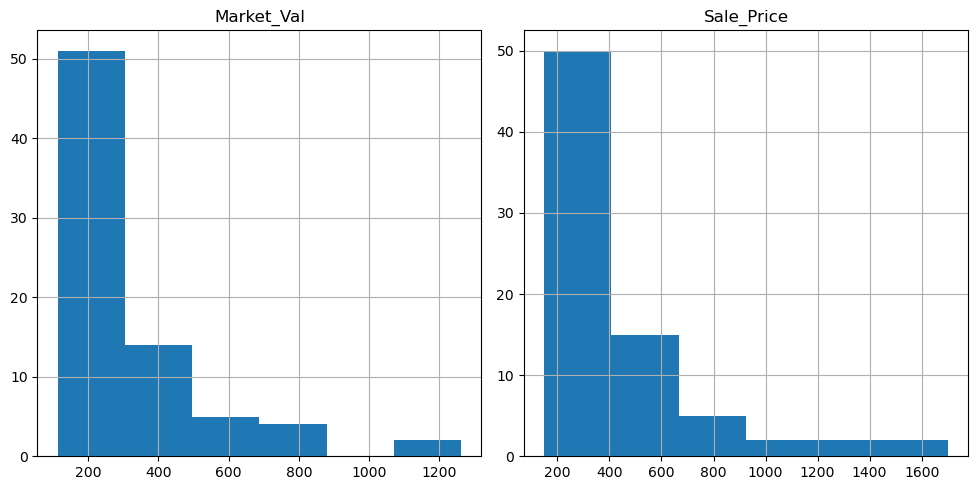

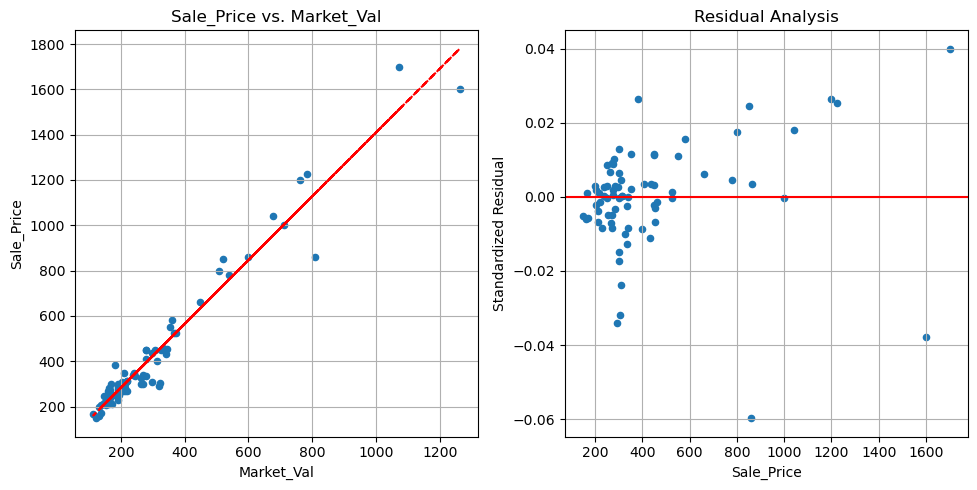

In [3]:
slr = SLR("../linear-regression/dataset/TAMPALMS.csv", "Market_Val", "Sale_Price")
slr.summary()